## Test the file dataset

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cart
import cartopy.io.img_tiles as cimgt
from cartopy.util import add_cyclic_point
import cartopy.mpl.ticker as cticker
import scipy.stats as stats
import calendar
from netCDF4 import Dataset
import plotly.graph_objects as go
from plotly.offline import iplot
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import nbformat

# create an animation of the ice concentration data
import matplotlib.animation as animation
import matplotlib.colors as mcolors  # import the color module in matplotlib

In [5]:
# Load data
file_path = r'C:\Users\bendo\OneDrive - George Mason University - O365 Production\Class\Clim680\data\ao.long.nc'
ao = xr.open_dataset(file_path)
ao


<xarray.Dataset> Size: 11kB
Dimensions:  (time: 896)
Coordinates:
  * time     (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2024-08-01
Data variables:
    value    (time) float32 4kB ...

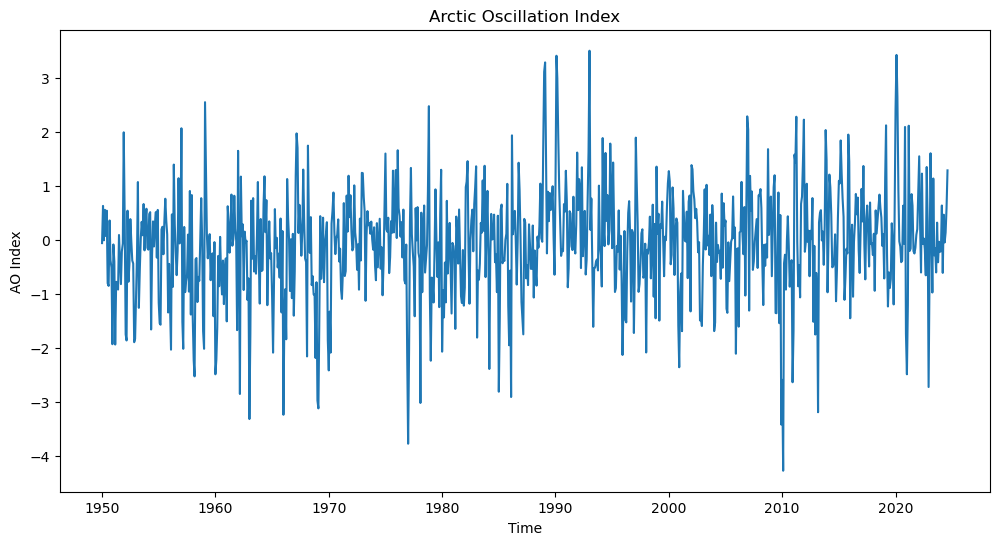

In [3]:
#plotting time series
plt.figure(figsize=(12,6))  #set the size of the plot
plt.plot(ao['time'],ao['value'])  #plot the data
plt.title('Arctic Oscillation Index')  #add a title
plt.ylabel('AO Index')  #add a y-axis label
plt.xlabel('Time')  #add an x-axis label
plt.show()  #show the plot

In [38]:
# Define colors for positive and negative values
colors = ['rgb(158,202,225)' if val >= 0 else 'rgb(255,99,71)' for val in ao['value'].values]

# Create the bar plot with conditional colors
fig = go.Figure(data=[go.Bar(x=ao['time'], y=ao['value'], marker_color=colors)])
fig.update_layout(title='Arctic Oscillation Index', xaxis_title='Time', yaxis_title='AO Index')

# Show the plot
iplot(fig)

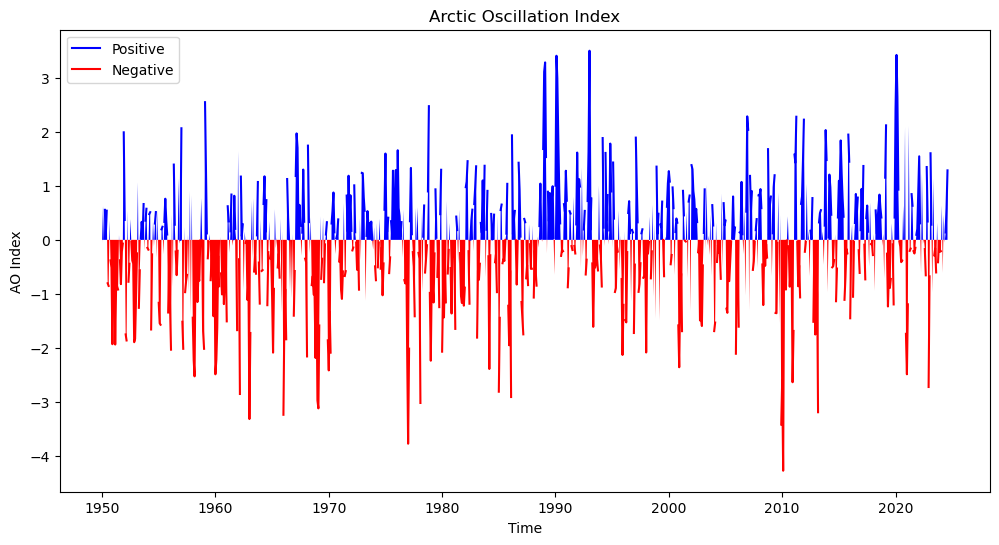

In [ ]:
#set positive and negative values
ao_pos = ao.where(ao['value'] > 0)
ao_neg = ao.where(ao['value'] < 0)

# change the color of the line based on the value
plt.figure(figsize=(12,6))  #set the size of the plot
plt.plot(ao_pos['time'],ao_pos['value'],'b',label='Positive')
plt.plot(ao_neg['time'],ao_neg['value'],'r',label='Negative')

# fill between the positive and negative values
plt.fill_between(ao['time'].values,0,ao['value'],where=ao['value']>=0,facecolor='blue',interpolate=True)
plt.fill_between(ao['time'].values,0,ao['value'],where=ao['value']<=0,facecolor='red',interpolate=True)

plt.title('Arctic Oscillation Index')  #add a title
plt.ylabel('AO Index')  #add a y-axis label
plt.xlabel('Time')  #add an x-axis label
plt.legend()    #add a legend
plt.show()  #show the plot


In [44]:
ao_pos

<xarray.Dataset> Size: 11kB
Dimensions:  (time: 896)
Coordinates:
  * time     (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2024-08-01
Data variables:
    value    (time) float32 4kB nan 0.627 nan 0.555 ... nan 0.136 0.587 1.284

In [7]:
# count the number of positive and negative values
pos = ao.where(ao['value'] > 0).count()
neg = ao.where(ao['value'] < 0).count()

# pos before 2000
pos_before = ao.where(ao['time.year'] < 2000).where(ao['value'] > 0).count()

# pos after 2000
pos_after = ao.where(ao['time.year'] >= 2000).where(ao['value'] > 0).count()

# results
# make a table with the results
results = pd.DataFrame({'Positive': [pos['value'].values[()]],
                        'Negative': [neg['value'].values[()]],
                        'Positive Before 2000': [pos_before['value'].values[()]],
                        'Positive After 2000': [pos_after['value'].values[()]]})    

results

# calculate the percentage of positive values
pos_percent = pos/(pos+neg)*100

# calculate the percentage of positive values for the time periods



# make a table with the results
results = pd.DataFrame({'Positive': [pos['value'].values[()]],
                        'Negative': [neg['value'].values[()]],
                        'Positive Before 2000': [pos_before['value'].values[()]],
                        'Positive After 2000': [pos_after['value'].values[()]],
                        'Positive (%)': [pos_percent['value'].values[()]],
                        'Positive Before 2000 (%)': [pos_before_percent['value'].values[()]],
                        'Positive After 2000 (%)': [pos_after_percent['value'].values[()]]})

results   


NameError: name 'pos_before_percent' is not defined

In [33]:
148/(24*12)*100

51.388888888888886

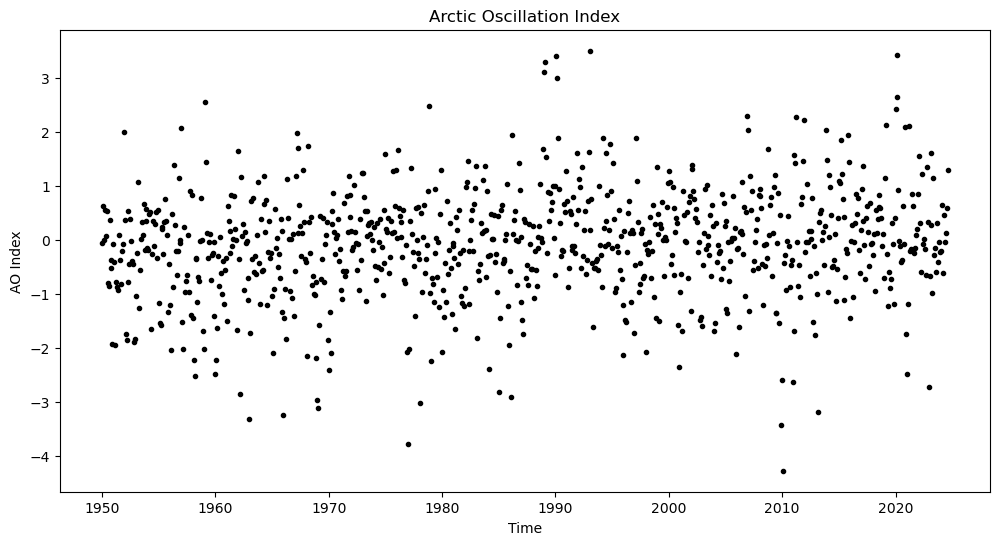

In [8]:
# make a point plot for AO index
plt.figure(figsize=(12,6))  #set the size of the plot
plt.plot(ao['time'],ao['value'],'k.')  #plot the data
plt.title('Arctic Oscillation Index')  #add a title
plt.ylabel('AO Index')  #add a y-axis label
plt.xlabel('Time')  #add an x-axis label
plt.show()  #show the plot

In [39]:
from matplotlib.dates import date2num

#create a Plotly figure
fig = go.Figure()

# Add a scatter plot of the AO index
fig.add_trace(go.Scatter(
    x=ao['time'],
    y=ao['value'],
    mode='markers',
    name='AO Index'))

# Convert datetime to numerical values
time_num = date2num(ao['time'].values)

# Perform a LOWESS regression
model1 = LinearRegression()
LR = model1.fit(time_num.reshape(-1,1), ao['value'].values)

# Add linear regression line
fig.add_trace(go.Scatter(
    x=ao['time'],
    y=LR.coef_*time_num + LR.intercept_,
    mode='lines',
    name='Linear Regression'))

# predict the AO index
y_pred = LR.predict(time_num.reshape(-1,1))
x_pred = ao['time']

# Perform a LOWESS smoothing
lowess = sm.nonparametric.lowess
y_lowess = lowess(ao['value'], time_num, frac=0.1)

# plot the LOWESS line
fig.add_trace(go.Scatter(
    x=ao['time'],
    y=y_lowess[:,1],
    mode='lines',
    name='LOWESS Smoothed'))

fig.update_layout(
    xaxis_title = 'Time',
    yaxis_title = 'AO Index',
    title='Arctic Oscillation Index',
    # center the title
    title_x=0.5,
    # add a legend at the bottom
    legend=dict(
        x=0,
        y=1,
        traceorder='normal',
        font=dict(
            family='sans-serif',
            size=12,
            color='black'
        ),
        bgcolor='LightSteelBlue',
        bordercolor='Black',
        borderwidth=2
    ),
    showlegend=True)

fig.show()

## Open Ice concentration dataset

In [6]:
# Open the file with the ice concentration data
thepath = r"C:\Users\bendo\OneDrive - George Mason University - O365 Production\Class\Clim680\data\icec.mon.mean.nc"
ds_icec = xr.open_dataset(thepath)

# Select the time period
ds_icec = ds_icec.sel(time=slice(ao['time'][0],ao['time'][-1]))
ds_icec

<xarray.Dataset> Size: 218MB
Dimensions:  (lat: 180, lon: 360, time: 840)
Coordinates:
  * lat      (lat) float32 720B 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2019-12-01
Data variables:
    icec     (time, lat, lon) float32 218MB ...
Attributes:
    title:            created 05/2014 from data provided by JRA
    history:          Created 12/2012 from data obtained from JRA by ESRL/PSD
    platform:         Analyses
    citation:         Hirahara, S., Ishii, M., and Y. Fukuda,2014: Centennial...
    institution:      NOAA ESRL/PSD
    Conventions:      CF-1.2
    dataset_title:    COBE-SST2 Sea Surface Temperature and Ice
    original_source:  https://climate.mri-jma.go.jp/pub/ocean/cobe-sst2/
    References:       https://www.psl.noaa.gov/data/gridded/cobe2.html

In [7]:
# Calculate Ice concentration anomaly
icec_climo = ds_icec.groupby('time.month').mean('time')
icec_anom = ds_icec.groupby('time.month') - icec_climo
icec_anom

<xarray.Dataset> Size: 218MB
Dimensions:  (lat: 180, lon: 360, time: 840)
Coordinates:
  * lat      (lat) float32 720B 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2019-12-01
    month    (time) int64 7kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    icec     (time, lat, lon) float32 218MB 0.005286 0.005571 0.005 ... nan nan

In [12]:
print(icec_anom)

<xarray.Dataset> Size: 218MB
Dimensions:  (lat: 180, lon: 360, time: 840)
Coordinates:
  * lat      (lat) float32 720B 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2019-12-01
    month    (time) int64 7kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    icec     (time, lat, lon) float32 218MB 0.005286 0.005571 0.005 ... nan nan


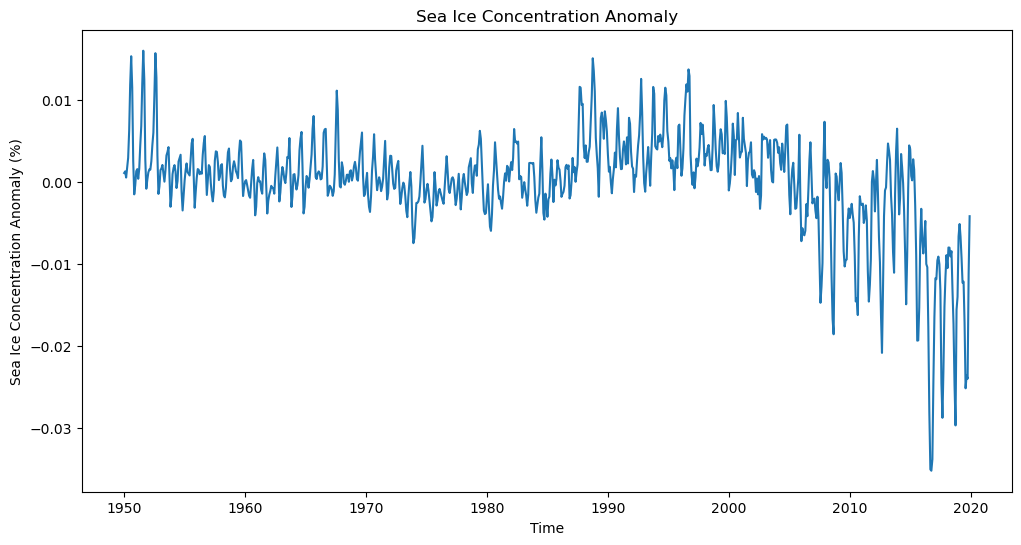

In [12]:
# Plot the ice concentration anomaly over time
plt.figure(figsize=(12,6))
plt.plot(icec_anom['time'],icec_anom['icec'].mean(dim=['lat','lon']), label='Ice Concentration Anomaly')
plt.title('Sea Ice Concentration Anomaly')
plt.ylabel('Sea Ice Concentration Anomaly (%)')
plt.xlabel('Time')
plt.show()  #show the plot



In [8]:
# Set a extent for the maps
extent = [-180, -100, 45, 80]

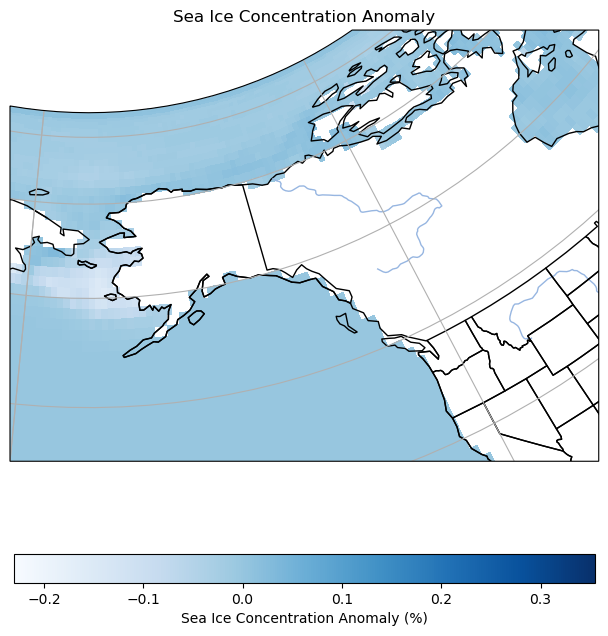

In [9]:
# Define the extent of the plot


# Plot the ice concentration anomaly
fig, ax = plt.subplots(figsize=(15,8), subplot_kw={'projection': ccrs.AlbersEqualArea(central_longitude=-170, central_latitude=60)})  
ax.set_extent(extent, ccrs.PlateCarree())  #set the extent of the plot
cs = ax.pcolormesh(icec_anom['lon'], icec_anom['lat'], icec_anom['icec'][0,:,:], cmap='Blues', transform=ccrs.PlateCarree())  #plot the data
ax.coastlines()  #add coastlines
ax.gridlines()  #add gridlines
# add rivers
ax.add_feature(cart.RIVERS)
# add states
ax.add_feature(cart.STATES)
ax.set_title('Sea Ice Concentration Anomaly')  #add a title
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)  #add a colorbar
cbar.set_label('Sea Ice Concentration Anomaly (%)')  #add a label to the colorbar
plt.show()  #show the plot


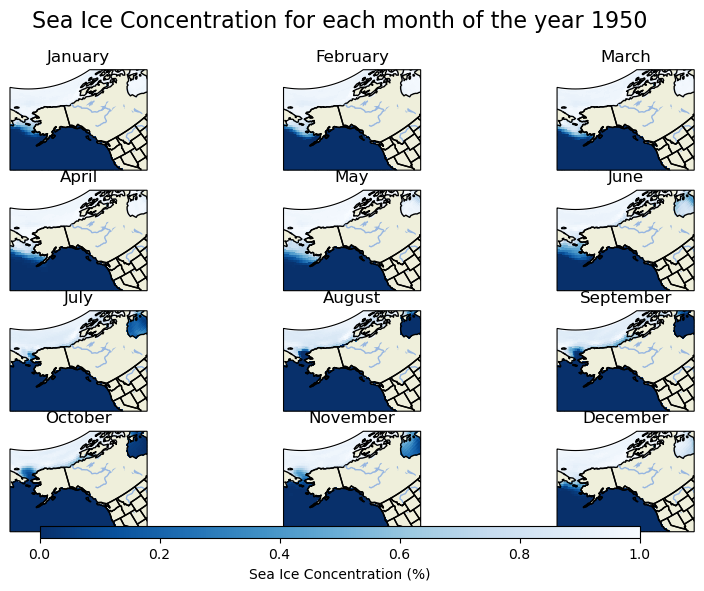

In [14]:
# Plot the ice concentration for each month of the year 1950
# Select data for the year 1950
ds_icec_1950 = ds_icec.sel(time='1950')

fig, ax = plt.subplots(4,3,figsize=(10,6), subplot_kw={'projection': ccrs.AlbersEqualArea(central_longitude=-170, central_latitude=60)})
axes = ax.flatten()

for i, ax in enumerate(axes):
    ax.set_extent(extent)
    ax.add_feature(cart.LAND)
    ax.add_feature(cart.COASTLINE)
    ax.add_feature(cart.BORDERS)
    ax.add_feature(cart.RIVERS)
    ax.add_feature(cart.STATES)
    ax.add_feature(cart.LAKES)
    ax.add_feature(cart.OCEAN)
    cs = ax.pcolormesh(ds_icec_1950['lon'], ds_icec_1950['lat'], ds_icec_1950['icec'][i,:,:],
                        cmap='Blues_r', transform=ccrs.PlateCarree())
    ax.set_title(calendar.month_name[i+1])

# add a colorbar 
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Sea Ice Concentration (%)')
fig.suptitle('Sea Ice Concentration for each month of the year 1950', fontsize=16)
plt.tight_layout
plt.show()

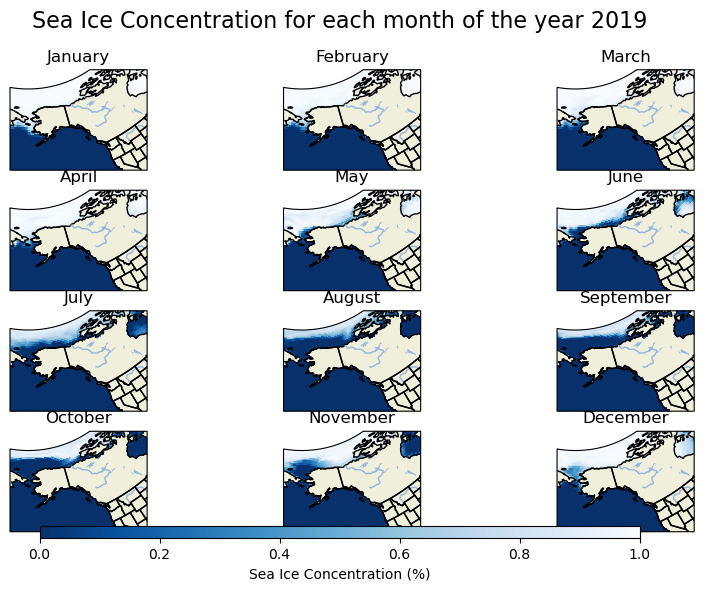

In [13]:
# Plot the ice concentration for each month of the year 2019
# Select data for the year 2019
ds_icec_2019 = ds_icec.sel(time='2019')

fig, ax = plt.subplots(4,3,figsize=(10,6), subplot_kw={'projection': ccrs.AlbersEqualArea(central_longitude=-170, central_latitude=60)})
axes = ax.flatten()

for i, ax in enumerate(axes):
    ax.set_extent(extent)
    ax.add_feature(cart.LAND)
    ax.add_feature(cart.COASTLINE)
    ax.add_feature(cart.BORDERS)
    ax.add_feature(cart.RIVERS)
    ax.add_feature(cart.STATES)
    ax.add_feature(cart.LAKES)
    ax.add_feature(cart.OCEAN)
    cs = ax.pcolormesh(ds_icec_2019['lon'], ds_icec_2019['lat'], ds_icec_2019['icec'][i,:,:], cmap='Blues_r', transform=ccrs.PlateCarree())
    ax.set_title(calendar.month_name[i+1])

# add a colorbar
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Sea Ice Concentration (%)')
fig.suptitle('Sea Ice Concentration for each month of the year 2019', fontsize=16)
plt.tight_layout
plt.show()

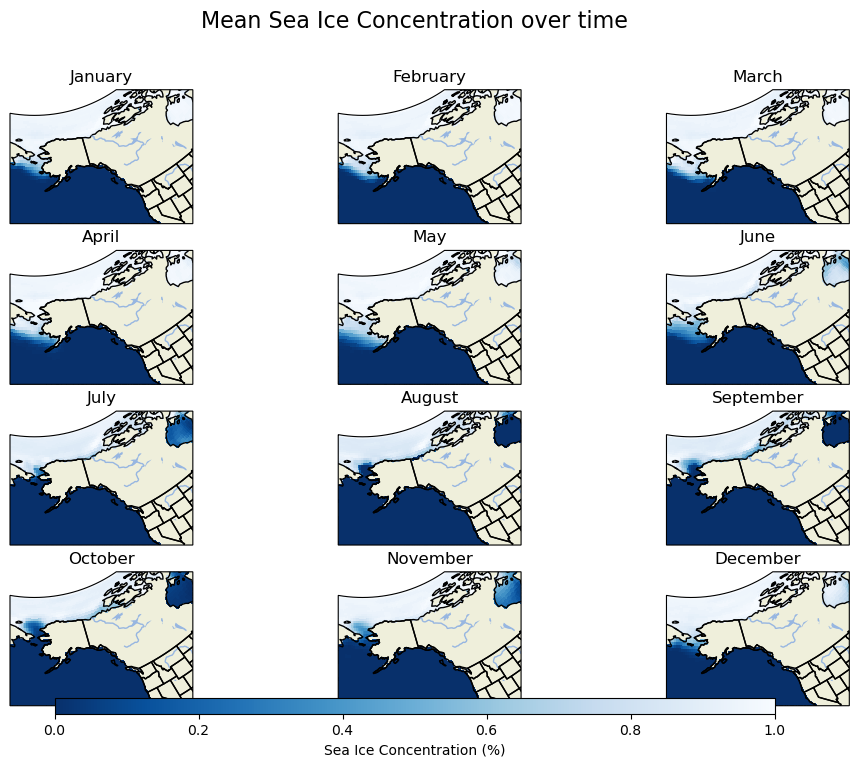

In [15]:
# Plot the ice concentration over time

fig, ax = plt.subplots(4,3,figsize=(12,8), subplot_kw={'projection': ccrs.AlbersEqualArea(central_longitude=-170, central_latitude=60)})
axes = ax.flatten()

for i, ax in enumerate(axes):
    ax.set_extent(extent)
    ax.add_feature(cart.LAND)
    ax.add_feature(cart.COASTLINE)
    ax.add_feature(cart.BORDERS)
    ax.add_feature(cart.RIVERS)
    ax.add_feature(cart.STATES)
    ax.add_feature(cart.LAKES)
    ax.add_feature(cart.OCEAN)
    cs = ax.pcolormesh(ds_icec['lon'], ds_icec['lat'], ds_icec['icec'][i,:,:], cmap='Blues_r', transform=ccrs.PlateCarree())
    ax.set_title(calendar.month_name[i+1])

# add a colorbar
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Sea Ice Concentration (%)')
fig.suptitle('Mean Sea Ice Concentration over time', fontsize=16)
plt.tight_layout
plt.show()

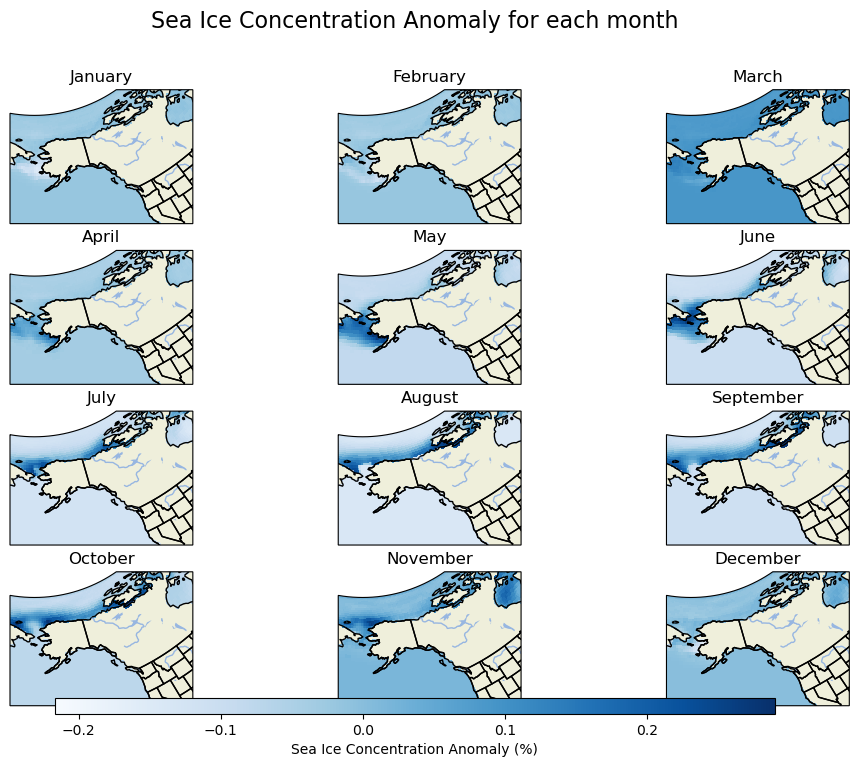

In [18]:
# Plot the ice concentration anomaly over time

fig, ax = plt.subplots(4,3,figsize=(12,8), subplot_kw={'projection': ccrs.AlbersEqualArea(central_longitude=-170, central_latitude=60)})
axes = ax.flatten()

for i, ax in enumerate(axes):
    ax.set_extent(extent)
    ax.add_feature(cart.LAND)
    ax.add_feature(cart.COASTLINE)
    ax.add_feature(cart.BORDERS)
    ax.add_feature(cart.RIVERS)
    ax.add_feature(cart.STATES)
    ax.add_feature(cart.LAKES)
    
    cs = ax.pcolormesh(icec_anom['lon'], icec_anom['lat'], icec_anom['icec'][i,:,:], cmap='Blues', transform=ccrs.PlateCarree())
    ax.set_title(calendar.month_name[i+1])
    ax.add_feature(cart.OCEAN)

# add a colorbar
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Sea Ice Concentration Anomaly (%)')
fig.suptitle('Sea Ice Concentration Anomaly for each month', fontsize=16)
plt.tight_layout
plt.show()

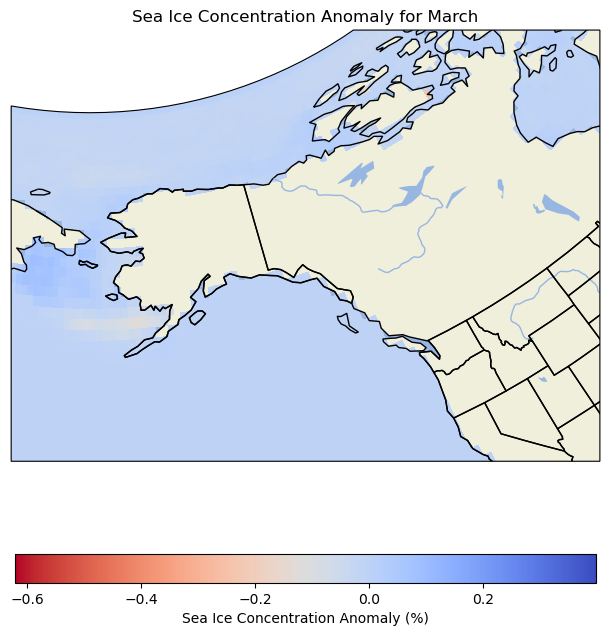

In [51]:
# Plot the ice concentration anomaly over time for March
ds_icec_March = icec_anom.sel(time=icec_anom['time.month']==3)

fig, ax = plt.subplots(figsize=(15,8), subplot_kw={'projection': ccrs.AlbersEqualArea(central_longitude=-170, central_latitude=60)})
ax.set_extent(extent)

cs = ax.pcolormesh(ds_icec_March['lon'], ds_icec_March['lat'], ds_icec_March['icec'][0,:,:], cmap='coolwarm_r', transform=ccrs.PlateCarree())   
ax.add_feature(cart.LAND)
ax.add_feature(cart.COASTLINE)
ax.add_feature(cart.BORDERS)
ax.add_feature(cart.RIVERS)
ax.add_feature(cart.STATES)
ax.add_feature(cart.LAKES)
ax.add_feature(cart.OCEAN)
ax.set_title('Sea Ice Concentration Anomaly for March')
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
cbar.set_label('Sea Ice Concentration Anomaly (%)')
plt.show()


MovieWriter imagemagick unavailable; using Pillow instead.


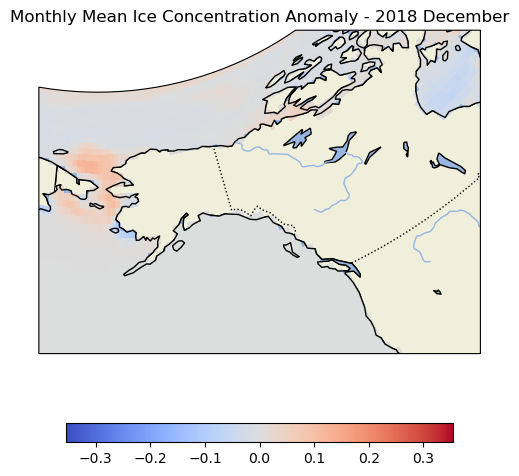

In [ ]:
# create an animation of the ice concentration Anomaly data
import matplotlib.animation as animation

# Create a figure and axis for the animation
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.AlbersEqualArea(central_longitude=-170, central_latitude=60)})
ax.set_extent(extent)
ax.add_feature(cart.BORDERS, linestyle=':')
ax.add_feature(cart.COASTLINE)
ax.add_feature(cart.LAND, edgecolor='black')
ax.add_feature(cart.OCEAN)
ax.add_feature(cart.LAKES, edgecolor='black')
ax.add_feature(cart.RIVERS)

# Initialize the plot with the first frame
icec_anom_1950_2018 = icec_anom['icec'].sel(time=slice('1950-01-01', '2018-12-31'))
ice_plot = icec_anom_1950_2018.isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', add_colorbar=False)

# Function to update the plot for each frame
def update(frame):
    ax.clear()
    ax.set_extent(extent)
    ax.add_feature(cart.BORDERS, linestyle=':')
    ax.add_feature(cart.COASTLINE)
    ax.add_feature(cart.LAND, edgecolor='black')
    ax.add_feature(cart.OCEAN)
    ax.add_feature(cart.LAKES, edgecolor='black')
    ax.add_feature(cart.RIVERS)
    ice_plot = icec_anom_1950_2018.isel(time=frame).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm_r', add_colorbar=False)
    time = pd.to_datetime(str(icec_anom_1950_2018['time'].values[frame]))
    ax.set_title(f'Monthly Mean Ice Concentration Anomaly - {time.year} {calendar.month_name[time.month]}')

# add colorbar
cbar = plt.colorbar(ice_plot, orientation='horizontal', shrink=0.5)

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(icec_anom_1950_2018['time']), repeat=True)

# Save the animation as a GIF
ani.save(r'C:\Users\rbendopa\OneDrive - George Mason University - O365 Production\Class\Clim680\Figs\animation.gif', writer='imagemagick')

plt.show()

MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


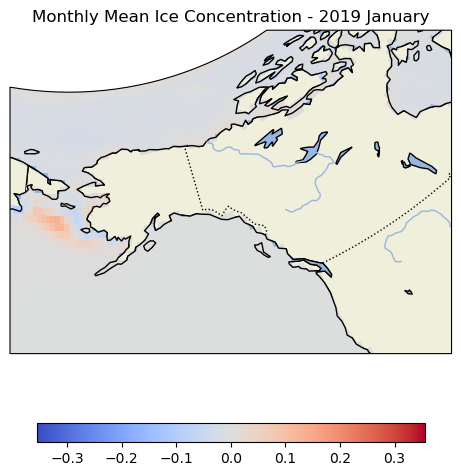

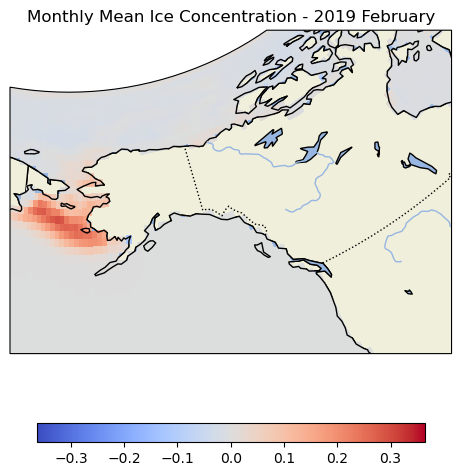

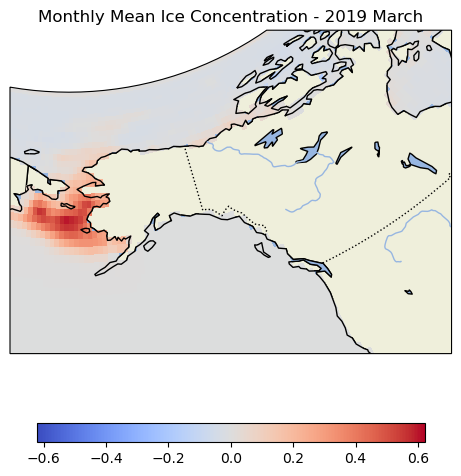

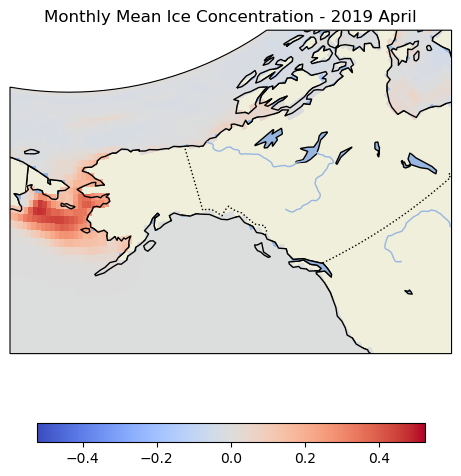

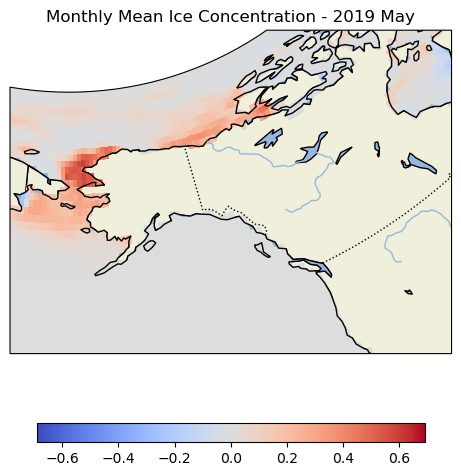

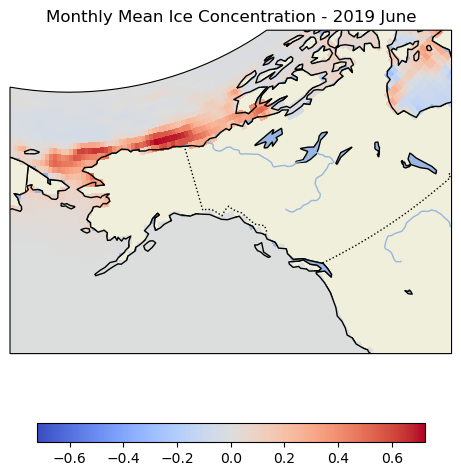

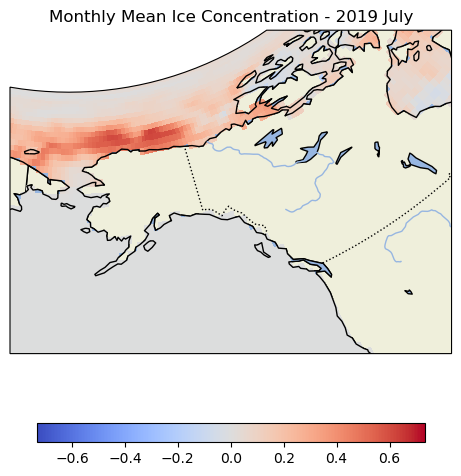

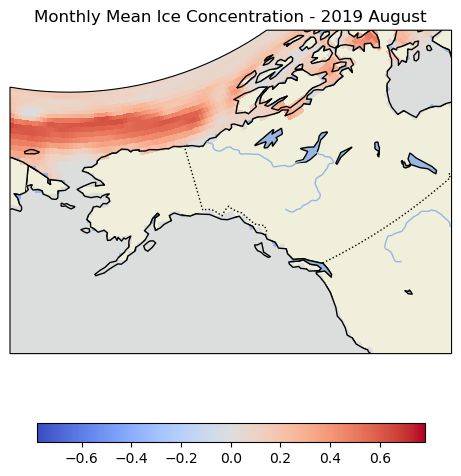

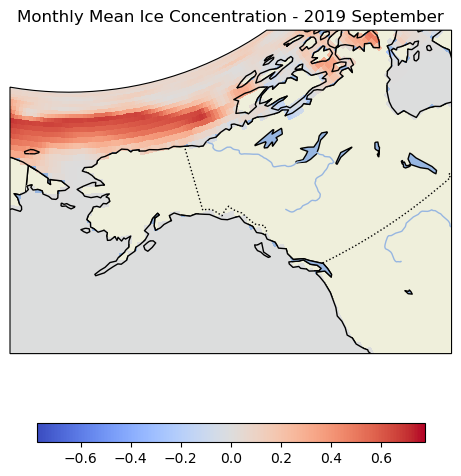

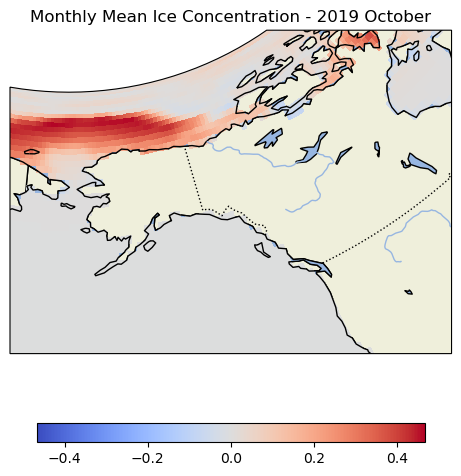

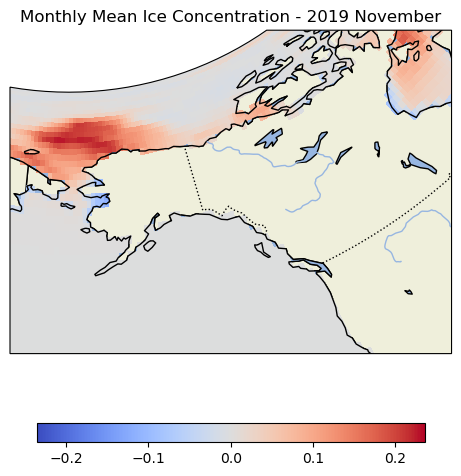

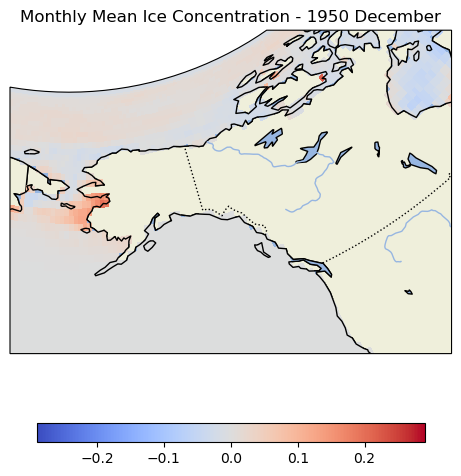

In [15]:
# Create a animation for each month

# Create a figure and axis for the animation
for month in range(1,13):
    
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.AlbersEqualArea(central_longitude=-170, central_latitude=60)})
    ax.set_extent(extent)
    ax.add_feature(cart.BORDERS, linestyle=':')
    ax.add_feature(cart.COASTLINE)
    ax.add_feature(cart.LAND, edgecolor='black')
    ax.add_feature(cart.OCEAN)
    ax.add_feature(cart.LAKES, edgecolor='black')
    ax.add_feature(cart.RIVERS)

    # Initialize the plot with the first frame
    icec_anom_month = icec_anom['icec'].sel(time=icec_anom['time.month']==month)
    ice_plot = icec_anom_month.isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', add_colorbar=False)

    # Function to update the plot for each frame
    def update(frame):
        ax.clear()
        ax.set_extent(extent)
        ax.add_feature(cart.BORDERS, linestyle=':')
        ax.add_feature(cart.COASTLINE)
        ax.add_feature(cart.LAND, edgecolor='black')
        ax.add_feature(cart.OCEAN)
        ax.add_feature(cart.LAKES, edgecolor='black')
        ax.add_feature(cart.RIVERS)
        ice_plot = icec_anom_month.isel(time=frame).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm_r', add_colorbar=False)
        time = pd.to_datetime(str(icec_anom_month['time'].values[frame]))
        
        ax.set_title(f'Monthly Mean Ice Concentration - {time.year} {calendar.month_name[time.month]}')

    # add colorbar
    cbar = plt.colorbar(ice_plot, orientation='horizontal', shrink=0.5)
    
    # Create the animation
    ani = animation.FuncAnimation(fig, update, frames=len(icec_anom_month['time']), repeat=True)

    # Save the animation as a GIF
    ani.save(r'C:\Users\rbendopa\OneDrive - George Mason University - O365 Production\Class\Clim680\Figs\animation_monthly_{}.gif'.format(month), writer='imagemagick')

In [46]:
ao_pos

<xarray.Dataset> Size: 11kB
Dimensions:  (time: 896)
Coordinates:
  * time     (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2024-08-01
Data variables:
    value    (time) float32 4kB nan 0.627 nan 0.555 ... nan 0.136 0.587 1.284

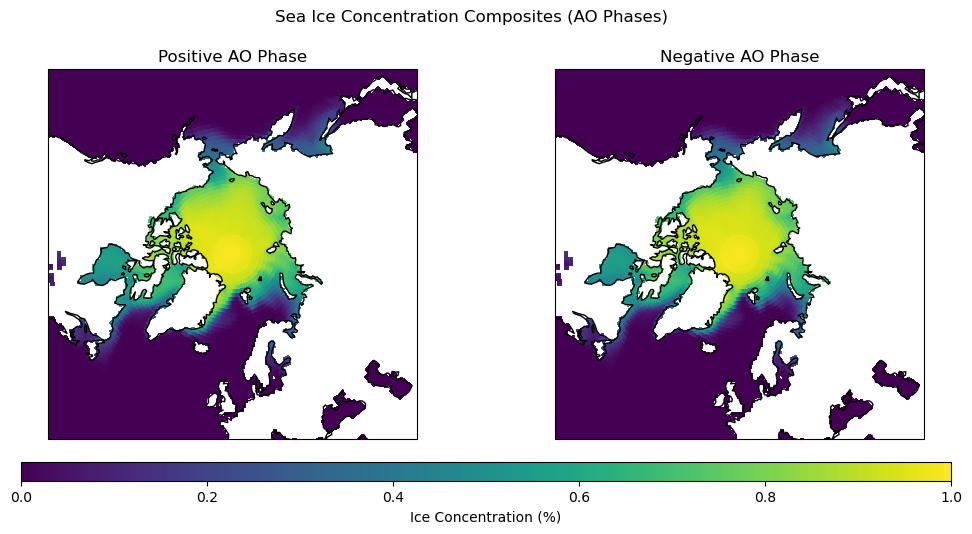

In [57]:
# Define thresholds for AO positive and negative phases
positive_phase = ao.where(ao['value'] > 0, drop=True)['time']
negative_phase = ao.where(ao['value'] < 0, drop=True)['time']

# Align the times in positive_phase and negative_phase with ds_icec
positive_phase_aligned = positive_phase.reindex_like(ds_icec['time'], method='nearest')
negative_phase_aligned = negative_phase.reindex_like(ds_icec['time'], method='nearest')

# Compute composites
positive_composite = ds_icec.sel(time=positive_phase_aligned).mean(dim='time')
negative_composite = ds_icec.sel(time=negative_phase_aligned).mean(dim='time')

# Plot the composites
fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.NorthPolarStereo()})

# Positive Phase
ax = axs[0]
positive_plot = ax.pcolormesh(
    ds_icec['lon'], ds_icec['lat'], positive_composite['icec'],
    transform=ccrs.PlateCarree(), cmap='viridis', vmin=0, vmax=1
)
ax.set_extent(extent, ccrs.PlateCarree())
ax.set_title("Positive AO Phase")
ax.coastlines()
ax.add_feature(cart.LAND, color='white')

# Negative Phase
ax = axs[1]
negative_plot = ax.pcolormesh(
    ds_icec['lon'], ds_icec['lat'], negative_composite['icec'],
    transform=ccrs.PlateCarree(), cmap='viridis', vmin=0, vmax=1
)
ax.set_extent(extent, ccrs.PlateCarree())
ax.set_title("Negative AO Phase")
ax.coastlines()
ax.add_feature(cart.LAND, color='white')

# Add colorbar
cbar = fig.colorbar(positive_plot, ax=axs, orientation='horizontal', pad=0.05, aspect=50, label="Ice Concentration (%)")

plt.suptitle("Sea Ice Concentration Composites (AO Phases)")
plt.show()


In [48]:
#How can I select the positive and negative AO index values that are associated with the ice concentration anomaly data?

# Align the times in ao_pos and ao_neg with icec_anom
ao_pos_aligned = ao_pos.dropna(dim='time').reindex_like(icec_anom, method='nearest')
ao_neg_aligned = ao_neg.dropna(dim='time').reindex_like(icec_anom, method='nearest')

# Select dates that match positive and negative AO index values
ao_pos_icec = icec_anom.sel(time=ao_pos_aligned['time']).mean(dim='time')
ao_neg_icec = icec_anom.sel(time=ao_neg_aligned['time']).mean(dim='time')

comp_icec = [ao_pos_icec, ao_neg_icec]
comp_icec

[<xarray.Dataset> Size: 261kB
 Dimensions:  (lat: 180, lon: 360)
 Coordinates:
   * lat      (lat) float32 720B 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
   * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
 Data variables:
     icec     (lat, lon) float32 259kB -5.4e-08 -1.135e-07 -1.057e-07 ... nan nan,
 <xarray.Dataset> Size: 261kB
 Dimensions:  (lat: 180, lon: 360)
 Coordinates:
   * lat      (lat) float32 720B 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
   * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
 Data variables:
     icec     (lat, lon) float32 259kB -5.4e-08 -1.135e-07 -1.057e-07 ... nan nan]

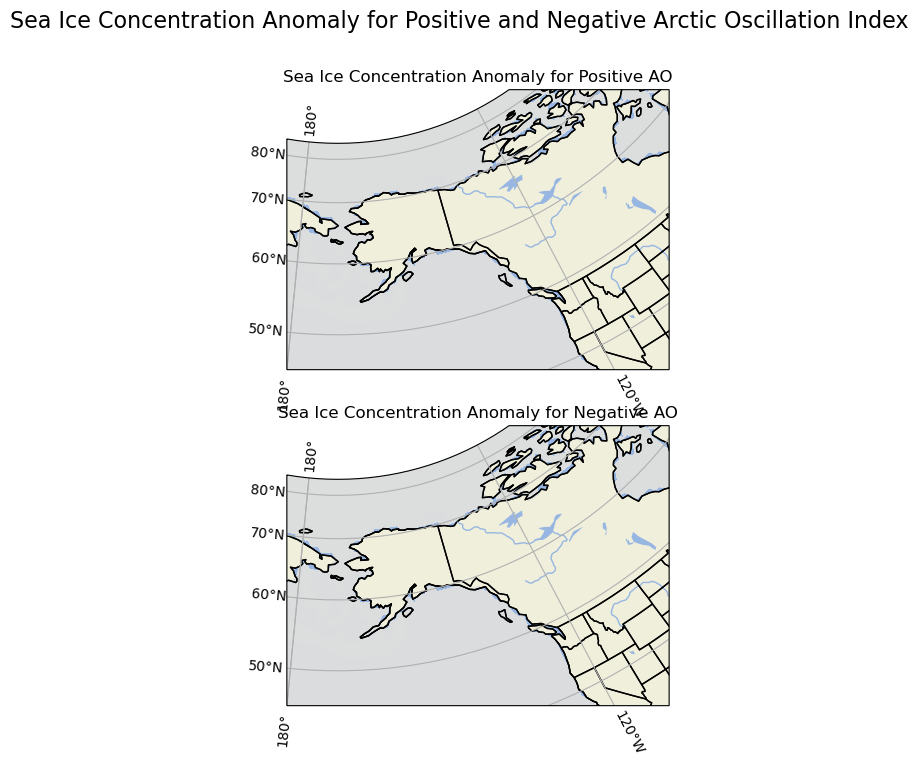

In [81]:
labels = ['Positive AO', 'Negative AO']
clevs = np.arange(-10, 10, 0.1)

# Define the figure and each axis for the 2 rows and 1 column
fig, ax = plt.subplots(nrows=2, ncols=1, 
                       figsize=(15, 8), 
                       subplot_kw={'projection': ccrs.AlbersEqualArea(central_longitude=-170, central_latitude=60)})

axes = ax.flatten()

# Loop over all of the months
for i, AO in enumerate(comp_icec):
    
    # Select the data
    data = comp_icec[i]

    # Add the cyclic point
    data_cyclic, lon_cyclic = add_cyclic_point(data['icec'], coord=comp_icec[i]['lon'])

    # Contour plot
    cs = axes[i].contourf(lon_cyclic, data['lat'], data_cyclic, clevs, 
                          cmap='coolwarm_r', transform=ccrs.PlateCarree(),
                          extend='both')

    # Longitude labels
    axes[i].set_extent(extent)
    
    gl = axes[i].gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False

    # Add coastlines
    axes[i].coastlines()

    # Title each subplot
    axes[i].set_title(f'Sea Ice Concentration Anomaly for {labels[i]}')
    axes[i].add_feature(cart.LAND)
    axes[i].add_feature(cart.COASTLINE)
    axes[i].add_feature(cart.BORDERS)
    axes[i].add_feature(cart.RIVERS)
    axes[i].add_feature(cart.STATES)
    axes[i].add_feature(cart.LAKES)
    axes[i].add_feature(cart.OCEAN)



# Add a big title
plt.suptitle('Sea Ice Concentration Anomaly for Positive and Negative Arctic Oscillation Index', fontsize=16)

plt.show()

## Checkin and undersatanding Composites

TypeError: cannot directly convert an xarray.Dataset into a numpy array. Instead, create an xarray.DataArray first, either with indexing on the Dataset or by invoking the `to_dataarray()` method.

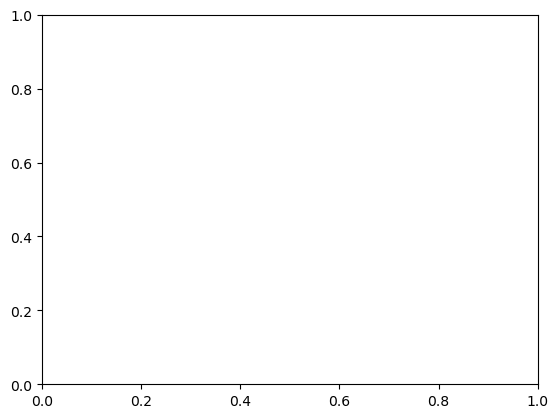

In [82]:
# high composite
pt1 = icec_anom.sel(lat=70, lon=-150-130, method='nearest')
plt.scatter(pt1, ao['value'], s=np.abs(2*pt1)+1)
plt.xlim(-10,10)
plt.ylim(-6,6)
plt.xlabel('Ice Concentration Anomaly (%)')
plt.ylabel('AO Index')

m, b = np.linalg.lstsq(np.vstack([pt1, np.ones(len(pt1))]).T, ao['value'], rcond=None)[0]
plt.plot(pt1, m*pt1 + b, 'r', label='Fitted line')

plt.axvline(0, color='darkturquoise', linewidth=0.5)
plt.axhline(1, color='black', linewidth =0.5, linestyle='dotted')
plt.axhline(0,color='black',linewidth=0.5)
plt.axhline(-1,color='black',linewidth=0.5,linestyle='dotted')

# Composite Significance

In [ ]:
# count 

## Significance Testing

In [104]:
# Calculate differences between positive and negative AO index values
diff__icec = [ao_pos_icec - ao_neg_icec,
                ao_neg_icec - ao_pos_icec]

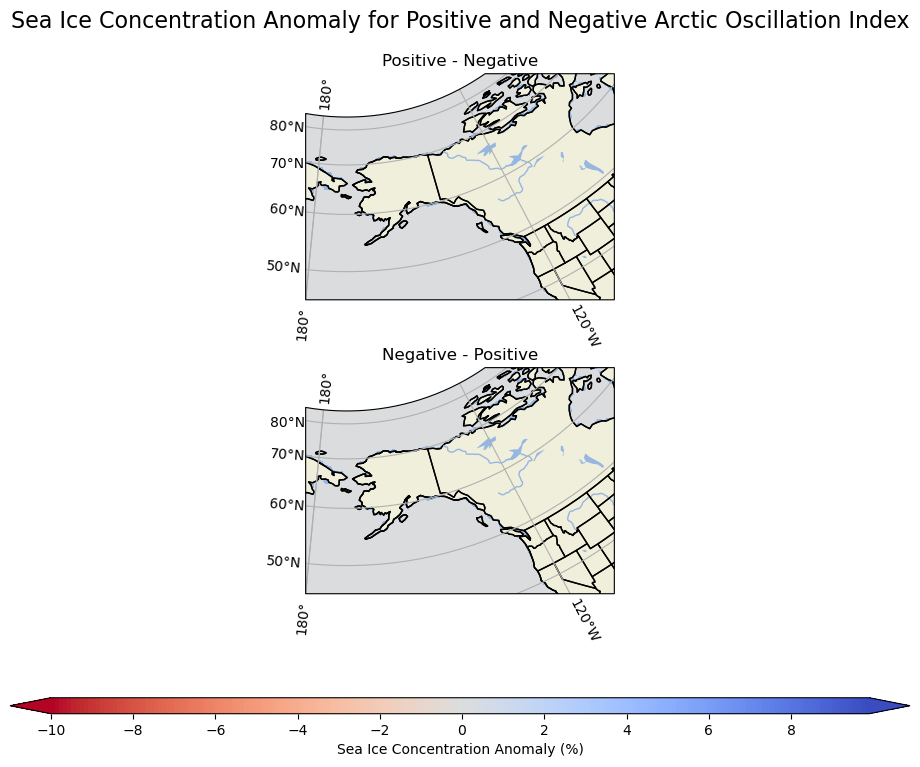

In [106]:
# Plot the differences
labels = ['Positive - Negative', 'Negative - Positive']
clevs = np.arange(-10, 10, 0.1)

# Define the figure and each axis for the 2 rows and 1 column
fig, ax = plt.subplots(nrows=2, ncols=1, 
                       figsize=(15, 8), 
                       subplot_kw={'projection': ccrs.AlbersEqualArea(central_longitude=-170, central_latitude=60)})
axes = ax.flatten()

# Loop over all of the months
for i, diff in enumerate(diff__icec):
    
    # Select the data
    data = diff__icec[i]

    # Add the cyclic point
    data_cyclic, lon_cyclic = add_cyclic_point(data['icec'], coord=diff__icec[i]['lon'])

    # Contour plot
    cs = axes[i].contourf(lon_cyclic, data['lat'], data_cyclic, clevs, 
                          cmap='coolwarm_r', transform=ccrs.PlateCarree(),
                          extend='both')

    # Longitude labels
    axes[i].set_extent(extent)
    
    gl = axes[i].gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False

    # Add coastlines
    axes[i].coastlines()

    # Title each subplot
    axes[i].set_title(f'{labels[i]}')
    axes[i].add_feature(cart.LAND)
    axes[i].add_feature(cart.COASTLINE)
    axes[i].add_feature(cart.BORDERS)
    axes[i].add_feature(cart.RIVERS)
    axes[i].add_feature(cart.STATES)
    axes[i].add_feature(cart.LAKES)
    axes[i].add_feature(cart.OCEAN)

# Adjust the location of the subplots
fig.subplots_adjust(bottom = 0.25, top = 0.9, left = 0.05, 
                    right = 0.95, wspace=0.3,hspace=0.3)

# Add a big title
plt.suptitle('Sea Ice Concentration Anomaly for Positive and Negative Arctic Oscillation Index', fontsize=16)

# Add a colorbar
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])

cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')

cbar.set_label('Sea Ice Concentration Anomaly (%)')

plt.show()

## Calculate Significance Using the built-in Stats Functions

In [107]:
p = 0.05 # 95% confidence level, or 5% likelihood that the result arose by chance

In [108]:
# T-statistic and p-value
ao_pos_icec_vals = icec_anom.sel(time=ao_pos_aligned['time'])['time']
ao_neg_icec_vals = icec_anom.sel(time=ao_neg_aligned['time'])['time']

In [110]:
tstat, pval = stats.ttest_ind(ao_pos_icec_vals, ao_neg_icec_vals, equal_var=False)

UFuncTypeError: ufunc 'add' cannot use operands with types dtype('<M8[ns]') and dtype('<M8[ns]')